In [139]:
import math
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


# B92 Involute Spline Optimizer

Written in the same format as shaft optimizer  

This only factors in root stresses of splines. Validate tubes by simplifying splines to the minimum diameter and the ID of the tube.   

All splines are assumed to be Fillet root with a side fit

## Material Definitions

Pulled from my torque selection script. I plan to make a library with materials and other useful methods included here.

In [121]:
#TODO add tensile strength

materials = { # all stresses are in lb-in^2, density lb/in^3
    'al7075' : {
        "material_name": 'al7075',
        "shear_stress": 48000,
        "tensile_stress": 73000,
        "density": .102,
    },
    'al6061' : {
        "material_name": 'al6061',
        "shear_stress": 30000,
        "tensile_stress": 42000,
        "density": .0975,
    },
    '4340' : {
        "material_name": '4340',
        "max_shear_stress": 185900,
        "max_tensile_stress": 185900,
        "density": 0.284,
    },
}

In [122]:
#Constants

## https://www.zakgear.com/External_Spline_tables.html

#TODO ADD CONSTANT CONSIDERATION
K_m = 1
#K_l = 2
#K_o = 1
#K_t = 1

L = 1 

pitch_selection = [2.5,3,4,5,6,8,10,12,16,20,24,32,40,48]

inp_torque = 300


## Tooth Geometry

I'm too lazy to go through the math behind this. These equations are pulled from B92 standards.

In [123]:
# tooth geometry

def get_pitch_diameter(N, P):
    return N/P

def get_tooth_height(N, P, φ): # major - minor diameter
    D_o = (N + 1)/P

    #for bmt (and my) sanity pressure angle will be assumed to be 30 degrees
    if P < 12 and P > 2.5:
        D_r = (N - 1.8)/P
    elif P < 16:
        D_r = (N - 2)/P
    else:
        D_r = (N - 2.3)/P
    
    return D_o - D_r
    

def get_tooth_thickness(P):
    return math.pi/(2*P)

def get_max_effective_length(pitch_diameter): # line fit for fixed splines with helix modification
    return -1 + 7/5*pitch_diameter

*All tooth geometry is a function of pressure angle, pitch diameter, and number of teeth. Equations are pulled from BDM-1550.*

## Max torsional stress of shaft

$T_{max}$ = $ \frac{\pi}{16}τ_{max}(d^4) $

$τ_{max}$ = Max Shear Stress  
$d$ = Max Diameter   
$t$ = Thickness   

In [132]:
def get_torsional_stress(τ_max, t, d):
    return (math.pi/16) * τ_max * ((d**4) - ((d - t)**4))/d

## Max shear stress on teeth

$t_c = \frac{D}{2N}$  

$τ_{max}$ = $\frac{4TK_m}{DNF_et_c} $

$T = \frac{τ_{max}DNF_et_c}{TK_m}$

$T$ = Torque in/lb  
$K_m$ = Load distribution factor   
$D$ = pitch diameter, in  
$N$ = number of spline teeth    
$F_e$ = effective spline contact length, in  
$t_c$ = chordal thickness at pitch line (D/2N), in  
$τ_{max}$ = Max shear stress of splines, psi  


In [125]:
def get_max_shear_torque(D, N, F_e, τ_max):
    t_c = D/2*N

    return (τ_max*D*N*F_e*t_c)/(4*K_m)

## Max compressive stress on teeth

$p_{max}$ = $\frac{2TK_m}{DNF_eh} $

$T = \frac{p_{max}DNF_eh}{TK_m}$

$T$ = Torque in/lb  
$K_m$ = Load distribution factor   
$D$ = pitch diameter, in  
$N$ = number of spline teeth    
$F_e$ = effective spline contact length, in  
$h$ = Tooth height, in  
$p_{max}$ = Max compressive stress of splines, psi  


In [126]:
def get_max_compressive_torque(D,N,F_e,p_max,h):
    return (p_max*D*N*F_e*h)/(2*K_m)

## Max torsional ID

$D_i = {(D_o^3-\frac{16T_{max}}{τ_{max}\pi})}^{\frac{1}{4}}$

$T_{max}$ = Max Torque, in/lb  
$D_h$ = Maximum ID, in  
$D_o$ = Input OD, in  
$τ_{max}$ = Max Shear Stress, psi  

In [127]:
def get_max_id(τ_max, T_max, D_o):
    return (D_o**3 - (16*T_max)/(τ_max*math.pi))**(1/4)

## Planar Mass

Get mass of planar cross section of tube

$M = \frac{\pi{d}}{2}^{2} - {\pi(\frac{d}{2} - t)}^{2}\rho$

$d$ = OD  
$t$ = Thickness  
$\rho$ = Density  

In [128]:
def get_tube_planar_mass(t, d, ρ):
    return (math.pi * (d/2)**2 - (math.pi * (d/2 - t)**2)) * ρ

## Max Torque

Takes the minimum torque value out of all the previously mentioned methods

In [148]:
def get_max_torque(N,L,H,D,id, S_c, S_sa):
    #max_shear_torque = get_max_shear_torque(D, N, L, S_sa)

    max_compressive_torque = get_max_compressive_torque(D,N,L,S_c,H)
    
    #max_torsional_torque = get_torsional_stress(S_sa, D - id, D).real

    
    return max_compressive_torque #min(max_shear_torque, max_compressive_torque)


## Plot

Simple 3D Plot using matplotlib

In [162]:
def NPplot(material, zaxis):
    ax = plt.axes(projection='3d')

    zdata = material[zaxis]
    xdata = material["N"]
    ydata = material["D"]
    
    ax.set_xlabel('N')
    ax.set_ylabel('D')
    ax.set_zlabel(zaxis)

    ax.set_zlim(0,200000)    
    ax.scatter3D(xdata, ydata, zdata, c=zdata)

    plt.title(material["material_name"])
    plt.show()
    

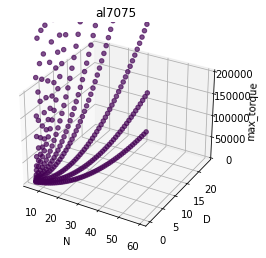

In [163]:
#for material_name, material in materials.items():
material = materials["al7075"]

material["P"] = []
material["N"] = []
material["D"] = []
material["max_torque"] = []
material["planar_mass"] = []
material["id"] = []

shear_stress = material["shear_stress"]
tensile_stress = material["tensile_stress"]

    # compressive_stress(N,L,H,D, S_c, K_m, K_l, K_o, K_t)

# https://www.zakgear.com/External_Spline_tables.html
for P in pitch_selection: 
    for N in range(6,60):
        D = get_pitch_diameter(N, P)
        H = get_tooth_height(N, P, 30)
        t = get_tooth_thickness(P)

        id = get_max_id(shear_stress, inp_torque, D)

        T = get_max_torque(N,L,H,D,id,tensile_stress,shear_stress)

        planar_mass = get_tube_planar_mass(D - id, D, material["density"])

        max_L = get_max_effective_length(D)

        if True:#(T > inp_torque): #or (max_L < L): # TODO: generate graphs without max effective length to see difference
            material["P"].append(P)
            material["D"].append(D)
            material["N"].append(N)
            material["max_torque"].append(T)
            material["id"].append(id)
            material["planar_mass"].append(planar_mass)

NPplot(material, "max_torque") # TODO write max_torque planar_mass cost function
#NPplot(material, "planar_mass") 

In [160]:
with open('output.csv', 'w') as f:
    writer = csv.writer(f)
    for value in range(len(material["P"])):
        writer.writerow([material["P"][value], material["N"][value], material["max_torque"][value], material["id"][value],material["planar_mass"][value]])
    